## Load-in dependencies:

In [1]:
using Pkg
# Pkg.add("Profile")
# Pkg.instantiate()

In [2]:
#= dependencies = ["DelimitedFiles", "LinearAlgebra", "Optim", "Distributions", "Test",
                "BenchmarkTools", "Random", "CSV", "DataFrames", "Distributed", "Plots"];
Pkg.add(dependencies) =#

In [3]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Plots
using Profile
using Distributed

In [4]:
pwd()

"/home/xyu/github/BulkLMM.jl/analysis"

In [5]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");
include("../src/scan_for_tests.jl")
include("../src/scan_distributed.jl") # new function

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

## Read in BXD data:

In [6]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [7]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

In [8]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [9]:
# Pkg.add("StatsBase")

In [10]:
using StatsBase

In [85]:
n_seeds = 20;

In [86]:
seeds_list = StatsBase.sample(1:100, n_seeds; replace = false)

20-element Vector{Int64}:
 47
 42
 97
 43
 96
  4
 94
 11
 51
 46
 48
 23
  9
  2
 83
 27
 56
 37
 34
 74

## Three phases of data transformations:

In [13]:
(y0, X0, lambda0) = transform1(pheno_y, geno, kinship);

In [14]:
# unique(round.(lambda0; digits = 3))

In [15]:
(r0, X00) = transform2(y0, X0, lambda0; reml = false);

## Study: distribute over permutations

### Check results:

Will the results be consistent, if we fixed the set of rotated data for further algorithm?

In [16]:
map_results = map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
map_LODs = reduce(vcat, map_results);

In [17]:
using Distributed

In [18]:
addprocs(20);

In [19]:
# procs()

In [20]:
# rmprocs([2, 3])

In [21]:
procs()

21-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21

In [22]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using Distributed
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [23]:
pmap_results = pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
pmap_LODs = reduce(vcat, pmap_results);

In [24]:
size(pmap_LODs)

(1000, 7321)

In [25]:
pmap_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.256678    0.256678    0.256678    0.256678    0.256678    0.256678
 0.0608784   0.0608784   0.0608784   0.0608784   0.0608784   0.0608784
 0.00186967  0.00186967  0.00186967  0.00186967  0.00186967  0.00186967
 0.128721    0.128721    0.128721    0.128721    0.128721    0.128721
 0.0241935   0.0241935   0.0241935   0.0241935   0.0241935   0.0241935
 0.00746149  0.00746149  0.00746149  0.00746149  0.00746149  0.00746149

In [26]:
map_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.256678    0.256678    0.256678    0.256678    0.256678    0.256678
 0.0608784   0.0608784   0.0608784   0.0608784   0.0608784   0.0608784
 0.00186967  0.00186967  0.00186967  0.00186967  0.00186967  0.00186967
 0.128721    0.128721    0.128721    0.128721    0.128721    0.128721
 0.0241935   0.0241935   0.0241935   0.0241935   0.0241935   0.0241935
 0.00746149  0.00746149  0.00746149  0.00746149  0.00746149  0.00746149

In [27]:
maxSqDiff(map_LODs, pmap_LODs) 

0.0

It turned out that if we give the same set of rotated data, results will match, which implies that the inconsistency of results may only be due to the rotation process (sign ambiguity in eigendecomposition).

### Benchmarking:

map(permutations)

In [28]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.479 s …   2.569 s  ┊ GC (min … max): 5.15% … 6.43%
 Time  (median):     2.524 s              ┊ GC (median):    5.80%
 Time  (mean ± σ):   2.524 s ± 63.945 ms  ┊ GC (mean ± σ):  5.80% ± 0.90%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.48 s         Histogram: frequency by time        2.57 s <

 Memory estimate: 13.48 GiB, allocs estimate: 737193.

pmap(permutations)

In [29]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  422.198 ms … 759.604 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     678.277 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   594.770 ms ± 137.832 ms  ┊ GC (mean ± σ):  0.07% ± 0.25%

  █  █    ██                                    █  ███        █  
  █▁▁█▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁███▁▁▁▁▁▁▁▁█ ▁
  422 ms           Histogram: frequency by time          760 ms <

 Memory estimate: 64.90 MiB, allocs estimate: 997.

In [30]:
@benchmark map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  2.454 s …   2.510 s  ┊ GC (min … max): 4.44% … 5.11%
 Time  (median):     2.474 s              ┊ GC (median):    4.79%
 Time  (mean ± σ):   2.479 s ± 28.328 ms  ┊ GC (mean ± σ):  4.78% ± 0.33%

  █                  █                                    █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.45 s         Histogram: frequency by time        2.51 s <

 Memory estimate: 13.47 GiB, allocs estimate: 737172.

In [88]:
@benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 50, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  395.265 ms … 855.746 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     403.569 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   488.600 ms ± 157.141 ms  ┊ GC (mean ± σ):  0.33% ± 1.30%

  █▄                                                             
  ██▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  395 ms           Histogram: frequency by time          856 ms <

 Memory estimate: 55.94 MiB, allocs estimate: 2413.

## Study: distribute over markers

### Check results:

In [32]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = true);

In [33]:
size(r0perm) 
# 401 permutations of a vector of length 79 (79 measurements), plus the original, for results checking with scan_null

(79, 1001)

In [34]:
map_eachMarker_LODs = map(x -> scan_distributed(r0perm, X00, x), 1:7321);
map_eachMarker_LODs = reduce(vcat, map_eachMarker_LODs);

In [35]:
pmap_eachMarker_LODs = pmap(x -> scan_distributed(r0perm, X00, x), 1:7321);
pmap_eachMarker_LODs = reduce(vcat, pmap_eachMarker_LODs);

In [36]:
scan_null_original = scan(pheno_y, geno, kinship)[3]; # original trait vector LODs

In [37]:
map_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [38]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [39]:
scan_null_original[1:6]

6-element Vector{Float64}:
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583

In [40]:
maxSqDiff(map_eachMarker_LODs, pmap_eachMarker_LODs)

7.888609052210118e-29

In [41]:
maxSqDiff(reshape(pmap_eachMarker_LODs[:, 1], :, 1), reshape(scan_null_original, :, 1))

3.077050568427709e-28

In [42]:
disLoops_LODs = scan_distributed(r0perm, X00);

In [43]:
disLoops_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [44]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [45]:
permutedims(scan_perms2(pheno_y, geno, kinship; nperms = 400, rndseed = 0, original = true))[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

### Benchmarking:

In [46]:
@benchmark map(x -> scan_distributed(r0perm, X00, x), 1:7321)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  2.495 s …  2.512 s  ┊ GC (min … max): 3.78% … 3.65%
 Time  (median):     2.502 s             ┊ GC (median):    3.77%
 Time  (mean ± σ):   2.503 s ± 8.688 ms  ┊ GC (mean ± σ):  3.77% ± 0.12%

  █                    █                                 █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.5 s         Histogram: frequency by time        2.51 s <

 Memory estimate: 13.29 GiB, allocs estimate: 109817.

In [47]:
@benchmark pmap(x -> scan_distributed(r0perm, X00, x), 1:7321)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 9.606 s (0.00% GC) to evaluate,
 with a memory estimate of 77.22 MiB, over 484931 allocations.

In [48]:
@benchmark scan_distributed(r0perm, X00) # using distributed loops for each marker

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.196 s …    1.449 s  ┊ GC (min … max): 0.37% … 0.41%
 Time  (median):     1.221 s               ┊ GC (median):    0.75%
 Time  (mean ± σ):   1.266 s ± 104.026 ms  ┊ GC (mean ± σ):  0.72% ± 0.39%

  █  █ █      █                                            █  
  █▁▁█▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.2 s          Histogram: frequency by time         1.45 s <

 Memory estimate: 752.16 MiB, allocs estimate: 2470.

In [49]:
 # using ordinary loops for each marker
@benchmark scan_perms2(pheno_y, geno, kinship; nperms = 1000, original = true, rndseed = 0)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.518 s …   2.641 s  ┊ GC (min … max): 3.21% … 3.98%
 Time  (median):     2.580 s              ┊ GC (median):    3.60%
 Time  (mean ± σ):   2.580 s ± 87.011 ms  ┊ GC (mean ± σ):  3.60% ± 0.54%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.52 s         Histogram: frequency by time        2.64 s <

 Memory estimate: 13.30 GiB, allocs estimate: 74635.

In [50]:
range = 1:6;
typeof(range)

UnitRange{Int64}

## Study: distribute over blocks of markers

### Check results:

In [51]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = true);

In [52]:
permutedims(scan_distributed_block(r0perm, X00, 1:6))[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [53]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [54]:
## https://stackoverflow.com/questions/26953340/partition-equivalent-in-julia

function partition_array_indices(nb_data::Int, nb_data_per_chunk::Int)
    nb_chunks = ceil(Int, nb_data / nb_data_per_chunk)
    ids = UnitRange{Int}[]
    for which_chunk = 1:nb_chunks
        id_start::Int = 1 + nb_data_per_chunk * (which_chunk - 1)
        id_end::Int = id_start - 1 + nb_data_per_chunk
        if id_end > nb_data
            id_end = nb_data
        end
        push!(ids, id_start:id_end)
    end
    return ids
end

partition_array_indices (generic function with 1 method)

In [55]:
blocks_partitions = partition_array_indices(p, 1000)

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [56]:
map_blocks_LODs = map(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
map_blocks_LODs = permutedims(reduce(hcat, map_blocks_LODs));

In [57]:
map_blocks_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [58]:
pmap_blocks_LODs = pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
pmap_blocks_LODs = permutedims(reduce(hcat, pmap_blocks_LODs));

In [59]:
pmap_blocks_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [60]:
normal_LODs = scan_perms2(pheno_y, geno, kinship; nperms = 1000, rndseed = 0, original = true);
normal_LODs = permutedims(normal_LODs);

In [61]:
normal_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [62]:
maxSqDiff(pmap_blocks_LODs, normal_LODs)

7.888609052210118e-29

### Benchmarking:

In [63]:
blocks_partitions

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [64]:
@benchmark map(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.792 s …  2.794 s  ┊ GC (min … max): 3.00% … 3.19%
 Time  (median):     2.793 s             ┊ GC (median):    3.10%
 Time  (mean ± σ):   2.793 s ± 1.433 ms  ┊ GC (mean ± σ):  3.10% ± 0.14%

  █                                                      █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.79 s        Histogram: frequency by time        2.79 s <

 Memory estimate: 13.27 GiB, allocs estimate: 73284.

In [65]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  488.056 ms … 937.970 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     750.036 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   754.594 ms ± 173.541 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █             █             █      █                  █   █ █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█▁█ ▁
  488 ms           Histogram: frequency by time          938 ms <

 Memory estimate: 55.96 MiB, allocs estimate: 1090.

In [66]:
@benchmark begin 
    transform1(pheno_y, geno, kinship);
    transform2(y0, X0, lambda0);
    pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
end

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  509.487 ms … 939.704 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     751.924 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   714.932 ms ± 149.797 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █  █                          █   █ █ █                     █  
  █▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  509 ms           Histogram: frequency by time          940 ms <

 Memory estimate: 82.87 MiB, allocs estimate: 1353.

In [67]:
@benchmark scan_perms2(pheno_y, geno, kinship; nperms = 1000, rndseed = 0, original = true)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.495 s …   2.520 s  ┊ GC (min … max): 2.82% … 2.89%
 Time  (median):     2.508 s              ┊ GC (median):    2.85%
 Time  (mean ± σ):   2.508 s ± 17.486 ms  ┊ GC (mean ± σ):  2.85% ± 0.05%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.5 s          Histogram: frequency by time        2.52 s <

 Memory estimate: 13.30 GiB, allocs estimate: 74635.

In [68]:
seeds_list

10-element Vector{Int64}:
 29
 58
 15
 87
 23
 48
  8
 96
 21
 53

In [69]:
@benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 50, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  521.952 ms … 879.590 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     757.438 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   738.942 ms ± 108.022 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁                                  ▁▁   █    ▁              ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  522 ms           Histogram: frequency by time          880 ms <

 Memory estimate: 55.90 MiB, allocs estimate: 1010.

## Compare times for different choices of nperms and block sizes:

In [70]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = false);

In [71]:
@everywhere nperms_list = [50, 100, 200, 500, 1000];
@everywhere bsizes_list = [100, 300, 500, 600, 1000];

In [72]:
runtimes_nperms = Array{Float64, 1}(undef, length(nperms_list));
runtimes_bsizes = Array{Float64, 1}(undef, length(bsizes_list));

In [73]:
procs() # check number of procs active rn

21-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21

In [74]:
blocks_partitions = partition_array_indices(p, 500)

15-element Vector{UnitRange{Int64}}:
 1:500
 501:1000
 1001:1500
 1501:2000
 2001:2500
 2501:3000
 3001:3500
 3501:4000
 4001:4500
 4501:5000
 5001:5500
 5501:6000
 6001:6500
 6501:7000
 7001:7321

In [75]:
size(r0perm)

(79, 1000)

In [76]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  444.367 ms … 894.241 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     627.615 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   642.234 ms ± 159.331 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █  █      █ █           █              █ █     █            █  
  █▁▁█▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  444 ms           Histogram: frequency by time          894 ms <

 Memory estimate: 55.91 MiB, allocs estimate: 1420.

In [77]:
for i in 1:length(nperms_list)
    
    np = nperms_list[i];
    nseeds = Int(1000/np);
    
    seeds_list = StatsBase.sample(1:100, nseeds; replace = false)
    b = @benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = $np, rndseed = x, original = false), seeds_list);
    b = median(b)
    
    runtimes_nperms[i] = time(b)/1e9
    
end

In [78]:
for i in 1:length(bsizes_list)
    
    bs = bsizes_list[i];
    
    blocks_partitions = partition_array_indices(p, bs);

    
    b = @benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
    b = median(b)
    
    runtimes_bsizes[i] = time(b)/1e9
    
end

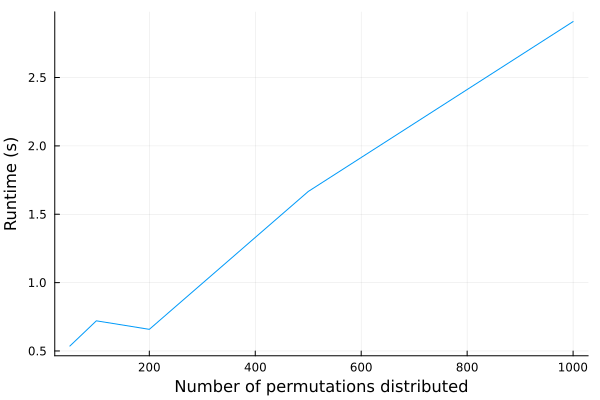

In [79]:
plot(nperms_list, runtimes_nperms; xlabel= "Number of permutations distributed", ylabel = "Runtime (s)", legend = false)

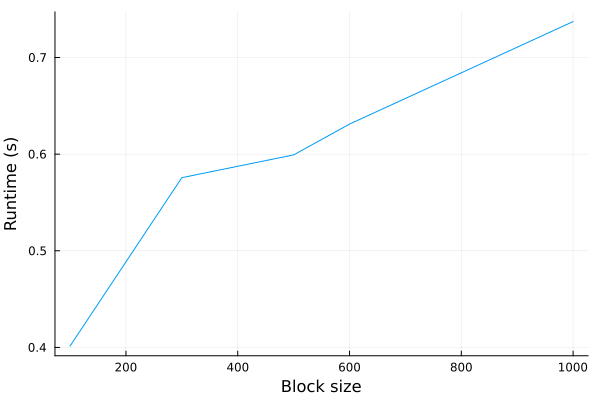

In [80]:
plot(bsizes_list, runtimes_bsizes; xlabel= "Block size", ylabel = "Runtime (s)", legend = false)

In [81]:
blocks_partitions = partition_array_indices(p, 100)

74-element Vector{UnitRange{Int64}}:
 1:100
 101:200
 201:300
 301:400
 401:500
 501:600
 601:700
 701:800
 801:900
 901:1000
 1001:1100
 1101:1200
 1201:1300
 ⋮
 6201:6300
 6301:6400
 6401:6500
 6501:6600
 6601:6700
 6701:6800
 6801:6900
 6901:7000
 7001:7100
 7101:7200
 7201:7300
 7301:7321

In [82]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 13 samples with 1 evaluation.
 Range (min … max):  388.611 ms … 403.443 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     394.818 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   395.894 ms ±   4.164 ms  ┊ GC (mean ± σ):  0.13% ± 0.48%

  █            ██     █  ███      █ █    █       █     █      █  
  █▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁█▁▁███▁▁▁▁▁▁█▁█▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁█ ▁
  389 ms           Histogram: frequency by time          403 ms <

 Memory estimate: 56.09 MiB, allocs estimate: 5915.

## Miscellaneous:

In [ ]:
n = size(y0, 1)

In [ ]:
Loops_y0 = Array{Float64, 2}(undef, n, 10);

In [ ]:
for i = 1:10
    Loops_y0[:, i] = rotateData(pheno_y, geno, kinship)[1]
end

first_col = Loops_y0[:, 1];

In [ ]:
test_list = mapslices(x -> x .- first_col, Loops_y0; dims = 1);

In [ ]:
test_list

In [ ]:
# addprocs(7);
procs()

In [ ]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using DelimitedFiles
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [ ]:
@everywhere begin 
    pheno_file = "../data/bxdData/BXDtraits.csv"
    pheno = readBXDpheno(pheno_file);
    geno_file = "../data/bxdData/BXDgeno_prob.csv"
    geno = readGenoProb_ExcludeComplements(geno_file);

    kinship = calcKinship(geno); # calculate kinship matrix from genotype data
end

In [ ]:
procs()

In [ ]:
# rmprocs([2, 3, 4, 5, 6, 7, 8, 9, 10])

In [ ]:
disLoops_y0 = @distributed (hcat) for i = 1:10
    rotateData(pheno_y, geno, kinship)[1]
end

first_dis_col = disLoops_y0[:, 1];


In [ ]:
test_dis_list = mapslices(x -> x .- first_dis_col, disLoops_y0; dims = 1);
test_dis_list

In [ ]:
pmaps_y0

In [ ]:
Loops_y0[1:15, 1:6]

In [ ]:
disLoops_y0[1:15, 1:6]

In [ ]:
scatter(disLoops_y0[1:15, 1])
scatter!(Loops_y0[1:15, 1]; legend = false)

In [ ]:
function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end